
**LinkdeIn Messages Analysis** 

This report includes analysis on my LinkdeIn messages. My motivation behin the analysis was, as an active user on LinkedIn with more than 300 conncetions, I was curious about the statistics of people in my network & the messages I received over the last 3 years.

This anaysis is divided into 3 parts : 
*   Langauage Detections
*   Getting Naming Entity & Pre-processing
*   Sentimental Analysis on Messages







In [ ]:
#Login to Datapane account
!datapane login --server=https://datapane.com/ --token=bab2643e89718f573850d62356b8654176094fb4


Logged in to https://datapane.com/ as lisa


In [ ]:
#Importing necessary Libiaries 
import pandas as pd 
import numpy as np 

#Data visaulations
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Pandas Profiling 
import pandas_profiling
from pandas_profiling import ProfileReport
                                                       
#Spacy 
import spacy 
from spacy import displacy
import scispacy  
from collections import Counter
from spacy_langdetect import LanguageDetector
import en_core_web_sm
from pprint import pprint

#WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Pre-Processing 
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from collections import Counter

#Sentimental Analysis 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [ ]:
#Load data
messages = pd.read_csv('messages.csv', engine='python')
messages.head(3)

,CONVERSATION ID,CONVERSATION TITLE,FROM,TO,DATE,SUBJECT,CONTENT,FOLDER
0,2-ZTFlNmZlMjMtZTczYy01YjM0LWE0YTktMDkzODA3ZWUz...,NaN,Perfect Strangers,Lisa Patel,2020-08-23 09:54:13 UTC,NaN,"<p class=""spinmail-quill-editor__spin-break"">H...",INBOX
1,2-YWY4ZTNjNGQtMTIxMS00OWU4LTkxYjYtOTNjMzc0Mzcw...,NaN,Lisa Patel,Victoria Garner,2020-08-23 08:18:53 UTC,NaN,"Hi Victoria, Hoping you’re well & good. It wa...",INBOX
2,2-Nzc3N2IyODMtNzA1Ny00OGI2LTliZWYtZmI0MmZkYzhh...,NaN,Jesse Anderson,Lisa Patel,2020-08-19 16:06:59 UTC,NaN,Is there a preferred time next week for a quic...,INBOX


In [ ]:
#Markdown for Datapane report 
figs = []
figs.append(dp.Markdown('# LinkedIn Messages'))
figs.append(dp.Table(messages.head(5)))


**Profiling Report**

In [ ]:
#Getting pandas profiling report 
profile = ProfileReport(messages, title='LinkedIn Profiling Report',html={'style': {'full_width': True}}, sort="None")
profile

In [ ]:
#Drop message without any content 
messages = messages.dropna(subset=['CONTENT'])
messages = messages.CONTENT

**Language Detection**</br>
Detecting the language of the message 

In [ ]:
#Language Detection
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text = 'This is an english text.'
doc = nlp(text)

#document level language detection
print(doc._.language)

#sentence level language detection
for sent in doc.sents:
   print(sent, sent._.language)

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



{'language': 'en', 'score': 0.9999963107619336}
This is an english text. {'language': 'en', 'score': 0.999995997700613}


In [ ]:
#Function for detecting English Text
def is_english(nlp, text):
    '''Detect whether a text is English'''

    return nlp(text)._.language['language'] == 'en'

#Function for extracting English Text
def extract_english_text(nlp, messages):
    '''Extract English text'''

    return [text for text in messages if is_english(nlp, text)]

In [ ]:
#Extracting English Text
english_messages = extract_english_text(nlp, messages)

**Name Entity**</br>
Detecting all the name entity from the messages(Named entity is a real-world object, such as persons, locations, organizations, products, etc.)


In [ ]:
#Fetching a message 
messages[5]

"Thank you so much, Lisa! I'd love to have a coffee chat and learn more about your awesome work - are you available for a 15-minute call in the next week?"

In [ ]:
#Load model
nlp = spacy.load("en_core_web_sm")

message1 = nlp(messages[5])

pprint([(word, word.label_) for word in message1.ents])


/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



[(Lisa, 'PERSON'), (the next week, 'DATE')]


In [ ]:
displacy.serve(message5, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [ ]:
#Joining all english messages
all_messages = nlp(' '.join(english_messages))

In [ ]:
#Function for getting all the Name entity 
labels = [x.label_ for x in all_messages.ents]
label_counter = Counter(labels)

def counter_to_df(counter):
    counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()\
    .rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)

    return counter_df
counter_df = counter_to_df(label_counter)

In [ ]:
#Visual for all the name entity 
fig = px.bar(counter_df,
      x='index',
      y='Count',
    title='Named Entity')
fig

In [ ]:
#Adding Figure to datapane report 
figs.append(dp.Plot(fig))

**Preprocessing Data**</br>
Preprocessing data my removing common words, html tags, special characters etc.

In [ ]:
#preprossing

def remove_html(words):
    '''Remove message with html'''
    return re.sub(r'^<p.*</p>', '', words)

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    return [re.sub(r'[^\w\s]', '', word) for word in words]

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    return [p.number_to_words(word) if word.isdigit() else word for word in words]

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    return [word for word in words if word not in stopwords.words('english')]

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    # Remove space
    words = ' '.join(words).replace('  ', ' ').strip().split(' ')
    try: 
        words.remove('')
    except:
        pass 
   
    return words

def preprocess(sample):
    sample = remove_html(sample)
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    #Tokenize
    words = nltk.word_tokenize(sample)

    #Normalize
    words = normalize(words)

    #Return sample
    return ' '.join(words)

In [ ]:
#Processing all the sentences 
processed = [preprocess(message) for message in english_messages]

In [ ]:
word_counter = Counter(' '.join(processed).split())

In [ ]:
wordcounter_df = counter_to_df(word_counter)

In [ ]:
#Removing empty string
while(" " in processed) : 
    processed.remove(" ")

In [ ]:
#Counting words by frequency
wordcounter_df.head(5)

,index,Count
34,lisa,122
0,hi,118
29,would,101
170,linkedin,86
100,thanks,74


In [ ]:
fig = px.bar(pd.DataFrame.from_dict(wordcounter_df[:30]),
      x='index',
      y='Count')
fig


In [ ]:
#Adding Figure to datapane report 
figs.append(dp.Plot(fig))

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline


def make_wordcloud(new_text):
    ''''funciton to make wordcloud'''
    
    wordcloud = WordCloud(width = 800, height = 800, 
                min_font_size = 10,
                background_color='black', 
                colormap='Set2', 
                collocations=False).generate(new_text) 
    
    #wordcloud.recolor(color_func = grey_color_func)

    
    fig = plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    
    return fig

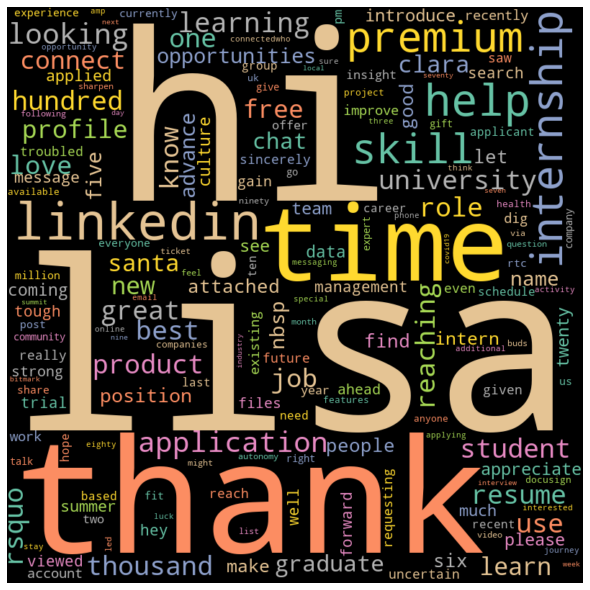

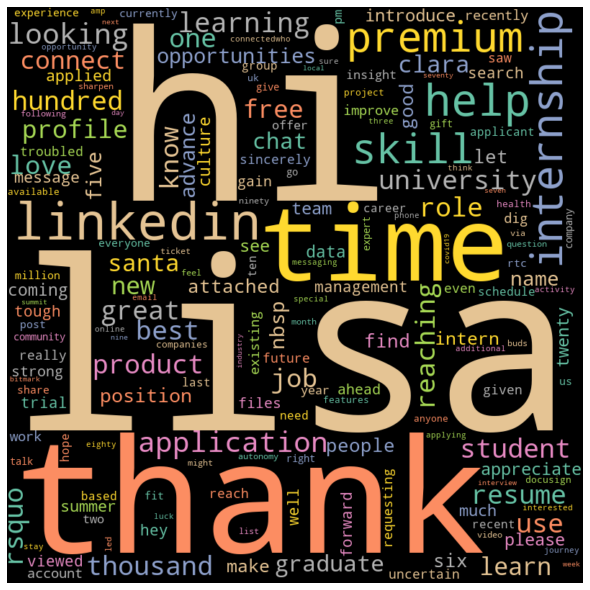

In [ ]:
word_cloud = make_wordcloud(' '.join(processed))
word_cloud


 **Sentimental Analysis**</br>
Predicting the Sentiment of my LinkedIn Messages. Here, I'm using a pre-trained dataset(Vader Library) as I do not have a dataset for training. 

In [ ]:
#Predicting sentiment of the Sentence 
sentence = 'I love this weather'
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



{'compound': 0.6369, 'neg': 0.0, 'neu': 0.323, 'pos': 0.677}

In [ ]:
#Sentiment Intensity Analyzer function 
def predict_sentiment(sentence):
    
    sentiment_dict = sid.polarity_scores(sentence)
    
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        return ("Positive", round(sentiment_dict['pos']*100, 2))
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        return ("Negative", round(sentiment_dict['neg']*100, 2))
  
    else : 
        return ("Neutral", round(sentiment_dict['neu']*100, 2))

In [ ]:
#Processed sentence
processed[3]

'sounds amazing wait chat'

In [ ]:
#Predicting Sentiment
predict_sentiment(processed[3])

('Positive', 55.9)

In [ ]:
#Predicting Sentiment
predict_sentiment('I am so sad')

('Negative', 62.9)

In [ ]:
#Predicting Sentiment
predict_sentiment('It is super useful')

('Positive', 77.3)

In [ ]:
#Storing all the messages to list for predicting sentiments 
sentiment = [predict_sentiment(message) for message in processed]

In [ ]:
#Dataframe with message and sentiment
sentiment_df = pd.concat([pd.DataFrame(processed, columns=['Message']), pd.DataFrame(sentiment, columns=['Sentiment', 'Confident'])], axis=1)
sentiment_df.head(10)

,Message,Sentiment,Confident
0,,Neutral,0.0
1,hi victoria hoping well good great learning ba...,Positive,52.0
2,preferred time next week quick chat,Neutral,100.0
3,sounds amazing wait chat,Positive,55.9
4,hi jesse sure know might help would love chat ...,Positive,56.8
5,thank much lisa would love coffee chat learn a...,Positive,47.4
6,hi jesse likewise work seems great girl lookin...,Positive,31.3
7,hi lisa saw profile rtc summit chat would love...,Positive,43.3
8,hi nicole apologies late response spent time c...,Positive,39.2
9,hey lisa thanks reaching working next couple w...,Positive,37.7


In [ ]:
#Visual of sentiments from all of my messages 
import plotly.express as px 

fig = px.histogram(sentiment_df, 
      x='Sentiment',
        title='Sentiment in my LinkedIn Message')
fig

In [ ]:
#Adding Figure to datapane report 
figs.append(dp.Plot(fig))


In [ ]:
#Visualizing positive & negative words
def visualise_sentiments(sentence):
    
    data = {
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
    }

    f, ax = plt.subplots()
    
    #Heatmap for positive or negative words 
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")
    return f

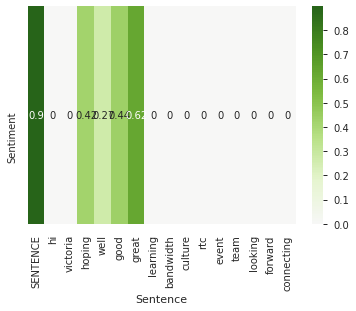

In [ ]:
#Performing Sentimental Analysis on a Sample for Positive words
sentence = list(sentiment_df[sentiment_df['Sentiment'] == 'Positive'].Message)[0]
plot = visualise_sentiments(sentence)

In [ ]:
#Adding Figure to datapane report 
figs.append(dp.Plot(fig))

In [ ]:
#Performing Sentimental Analysis on a Sample for Negative words
sample = list(sentiment_df[sentiment_df['Sentiment'] == 'Negative'].Message)[2]

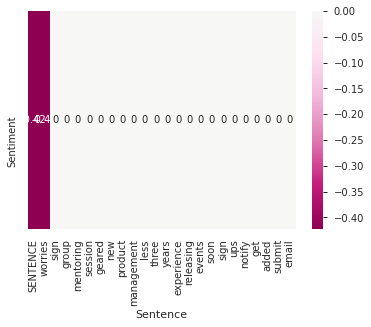

In [ ]:
#Visual of the sample words
fig = visualise_sentiments(sample)

In [ ]:
#Adding Figure to datapane report 
figs.append(dp.Plot(fig))

Publishing Report to Datapane

In [ ]:
##Create a Report for the Plots
dp.Report(*figs).publish(name='Linkedin_message', open=True)

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/lisa/reports/Linkedin_message/
